Using the client data aggregated in the [data pre-processing notebook](data_prep.ipynb), we'll now take a look at how the different clients active on the Medalla testnet compared.

Of course, as already mentioned, this analysis relies on the truthfulness of validators' block graffiti. It is also a snapshot in time. All the eth2 clients have continued to be developed and refined throughout the period under review. Problems apparent in the earlier phases may already have been resolved.

In [1]:
# imports
import psycopg2
import math
import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

In [ ]:
# get info about dataset and validators

cursor.execute("SELECT MAX(f_slot) FROM t_blocks")
latest_slot = cursor.fetchone()[0]
n_slots = latest_slot + 1
n_epochs = (n_slots - (n_slots % 32)) // 32

cursor.execute("SELECT f_activation_eligibility_epoch, f_activation_epoch, f_exit_epoch, f_slashed, "
               "f_first_attested_epoch, f_latest_attested_epoch, f_client, f_proposed_count "
               "FROM t_validators ORDER BY f_index")
result = cursor.fetchall()
validators = [{"activation_eligibility_epoch": r[0],
               "activation_epoch"            : r[1],
               "exit_epoch"                  : r[2],
               "slashed"                     : r[3],
               "first_attestation"           : r[4],
               "latest_attestation"          : r[5],
               "client"                      : r[6],
               "proposed_count"              : r[7]} for r in result]

## Client proportions
It turns out that the majority of validators (71%) did not provide information in block graffiti which could be used to identify the client used. This includes all validators which did not propose any blocks, since graffiti is only supplied by the block producer. For this reason, validators who were *absent* or those which did not participate long enough to propose any blocks, are excluded.

Number of validators: 80328
22347 provided client info (27.8%)
41693 no info (51.9%)
16288 no blocks produced (20.3%)


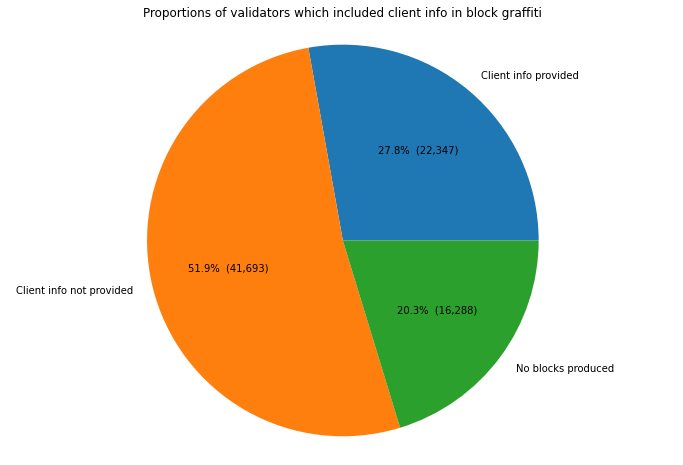

Number of validators providing client info: 22347
10046 Prysm (45.0%)
 6656 Lighthouse (29.8%)
 1869 Teku (8.4%)
 1500 Nimbus (6.7%)
   99 Lodestar (0.4%)
 2177 ambiguous (9.7%)


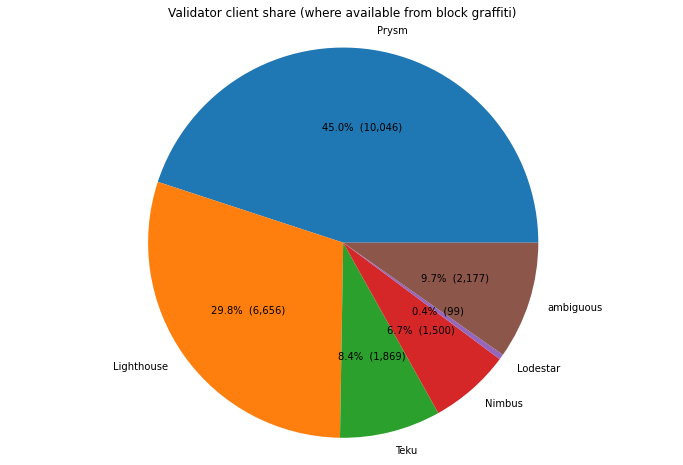

In [4]:
# determine validator clients from block graffiti

cursor.execute(f"SELECT f_proposer_index, f_graffiti FROM t_blocks WHERE f_canonical = true")
proposers = cursor.fetchall()

for _, validator in validators.items():
    validator["client"] = ""
    validator["producer"] = False

for proposer in proposers:
    validator = validators[proposer[0]]
    validator["producer"] = True
    graffiti = proposer[1].tobytes().decode(errors='ignore').lower()
    
    if validator["client"] == "ambiguous":
        continue
    
    pr_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "a") or graffiti.find("prysm") != -1 else 0
    li_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "b") or graffiti.find("lighthouse") != -1 else 0
    te_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "c") or graffiti.find("teku") != -1 else 0
    ni_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "d") or graffiti.find("nimbus") != -1 else 0
    lo_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "e") or graffiti.find("lodestar") != -1 else 0
    n_flags = pr_flag + li_flag + te_flag + ni_flag + lo_flag
    
    if n_flags > 1:
        validator["client"] = "ambiguous"
    elif pr_flag:
        validator["client"] = "prysm" if validator["client"] in ["", "prysm"] else "ambiguous"
    elif li_flag:
        validator["client"] = "lighthouse" if validator["client"] in ["", "lighthouse"] else "ambiguous"
    elif te_flag:
        validator["client"] = "teku" if validator["client"] in ["", "teku"] else "ambiguous"
    elif ni_flag:
        validator["client"] = "nimbus" if validator["client"] in ["", "nimbus"] else "ambiguous"
    elif lo_flag:
        validator["client"] = "lodestar" if validator["client"] in ["", "lodestar"] else "ambiguous"

pr_count = li_count = te_count = ni_count = lo_count = amb_count = 0
for _, validator in validators.items():
    if validator["client"] == "prysm":
        pr_count += 1
    elif validator["client"] == "lighthouse":
        li_count += 1
    elif validator["client"] == "teku":
        te_count += 1
    elif validator["client"] == "nimbus":
        ni_count += 1
    elif validator["client"] == "lodestar":
        lo_count += 1
    elif validator["client"] == "ambiguous":
        amb_count += 1

no_blocks_count = sum(not v["producer"] for _, v in validators.items())
no_info_count = sum(v["client"] == "" for _, v in validators.items()) - no_blocks_count
client_info_count = len(validators) - no_blocks_count - no_info_count

print(f"Number of validators: {len(validators)}")
print(f"{client_info_count:5} provided client info ({100*client_info_count/len(validators):.1f}%)")
print(f"{no_info_count:5} no info ({100*no_info_count/len(validators):.1f}%)")
print(f"{no_blocks_count:5} no blocks produced ({100*no_blocks_count/len(validators):.1f}%)")

labels = ['Client info provided', 'Client info not provided', 'No blocks produced']
counts = [client_info_count, no_info_count, no_blocks_count]
fig0, ax0 = plt.subplots(figsize=(12,8))
ax0.pie(counts, labels=labels, autopct=lambda p: f"{p:.1f}%  ({p * sum(counts)/100:,.0f})")
ax0.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportions of validators which included client info in block graffiti')
plt.show()

print(f"Number of validators providing client info: {client_info_count}")
print(f"{pr_count:5} Prysm ({     100*pr_count  / client_info_count:.1f}%)")
print(f"{li_count:5} Lighthouse ({100*li_count  / client_info_count:.1f}%)")
print(f"{te_count:5} Teku ({      100*te_count  / client_info_count:.1f}%)")
print(f"{ni_count:5} Nimbus ({    100*ni_count  / client_info_count:.1f}%)")
print(f"{lo_count:5} Lodestar ({  100*lo_count  / client_info_count:.1f}%)")
print(f"{amb_count:5} ambiguous ({100*amb_count / client_info_count:.1f}%)")

labels = ['Prysm', 'Lighthouse', 'Teku', 'Nimbus', 'Lodestar', 'ambiguous']
counts = [pr_count, li_count, te_count, ni_count, lo_count, amb_count]
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.pie(counts, labels=labels, autopct=lambda p: f"{p:.1f}%  ({p * sum(counts)/100:,.0f})")
ax1.axis('equal')
plt.title('Validator client share (where available from block graffiti)')
plt.show()

In [5]:
# calculate participation rates, mean inclusion distance and attestation effectiveness for each client
# if the attestation is missed and the validator has not yet done any attestations, it is considered dormant
# if the attestation is missed and there are no future attestations, it is considered abandoned

start_time = time.time()

empty = [0] * n_epochs
clients = ["prysm", "lighthouse", "teku", "nimbus"]
success_count   = {client:empty.copy() for client in clients}
absent_count    = {client:empty.copy() for client in clients}
dormant_count   = {client:empty.copy() for client in clients}
abandoned_count = {client:empty.copy() for client in clients}
missed_count    = {client:empty.copy() for client in clients}
sum_distance    = {client:empty.copy() for client in clients}
sum_ae          = {client:empty.copy() for client in clients}

for slot in range(latest_slot+1):
    validator_scores, validator_ae = attestation_performance(cursor, slot)
    epoch = slot // 32
    for validator_index in validator_scores:
        client = validators[validator_index]["client"]
        if client not in clients:
            continue
        if validator_scores[validator_index] != -1:
            success_count[client][epoch]   += 1
            sum_distance[client][epoch]    += validator_scores[validator_index]
            sum_ae[client][epoch]          += validator_ae[validator_index]
        elif validators[validator_index]["latest_attestation"] == -1:
            absent_count[client][epoch]    += 1
        elif slot < validators[validator_index]["first_attestation"]:
            dormant_count[client][epoch]   += 1
        elif slot > validators[validator_index]["latest_attestation"]:
            abandoned_count[client][epoch] += 1
        else:
            missed_count[client][epoch]    += 1

    seconds = time.time() - start_time
    elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
    left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((latest_slot+1) / (slot+1)-1)))
    percentage = 100*(slot+1)/(latest_slot+1)
    print(f"Epoch {epoch} of {latest_slot//32} ({percentage:.2f}%). "
          f"{elapsed} elapsed. {left} left.", end='\r')

mean_inclusion_distance = {}
attestation_effectiveness = {}
for client in clients:
    mean_inclusion_distance[client] = [sum_distance[client][e] / success_count[client][e] 
                                       if success_count[client][e] > 0 else None for e in range(n_epochs)]
    attestation_effectiveness[client] = [100 * sum_ae[client][e] / 
                                                          (success_count[client][e] + missed_count[client][e])
                                        for e in range(n_epochs)]
    
print(f"Pass completed in {elapsed}." + ' ' * 50)

Pass completed in 02:11:13.                                                  


## Participation rate
Let's have a look at how the participation rates for the different clients compare. As in the previous notebook, we're going to ignore *dormant* and *abandoned* validators. As mentioned above, *absent* validators are already excluded from this dataset. Also, given the very low number of validators self-identifying as Lodestar, this client will be excluded from the remaining analysis, since any results from such a small sample would be unreliable.

The lines below have also been smoothed with a 16-epoch moving average, as they are a bit too fuzzy to compare between clients otherwise.

              prysm    lighthouse          teku        nimbus
count  15238.000000  15238.000000  15238.000000  15238.000000
mean      87.635560     77.818117     85.422726     50.087501
std       21.642902     25.700871     20.953113     31.519909
min        0.000000      0.000000      0.000000      0.000000
25%       90.447922     63.383742     86.604543     23.549724
50%       94.261252     92.225358     90.380184     51.164453
75%       96.825669     95.621977     94.541910     78.005343
max      100.000000    100.000000    100.000000    100.000000


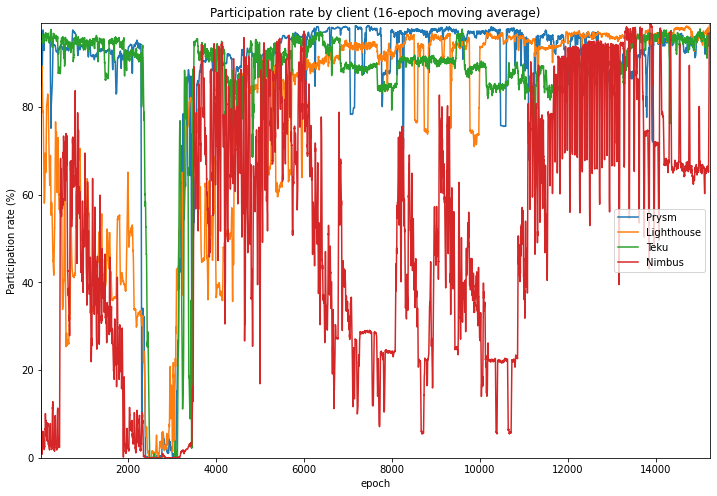

              prysm    lighthouse          teku        nimbus
count  10238.000000  10238.000000  10238.000000  10238.000000
mean      93.922359     92.267645     90.266614     57.450233
std        5.652671      7.543747      5.037551     28.103246
min       55.758201     54.418262     18.465909      4.166667
25%       92.450210     92.103394     87.113703     28.680028
50%       96.109257     94.966887     90.231570     62.905015
75%       97.366127     96.288826     94.007264     84.214232
max      100.000000    100.000000    100.000000    100.000000


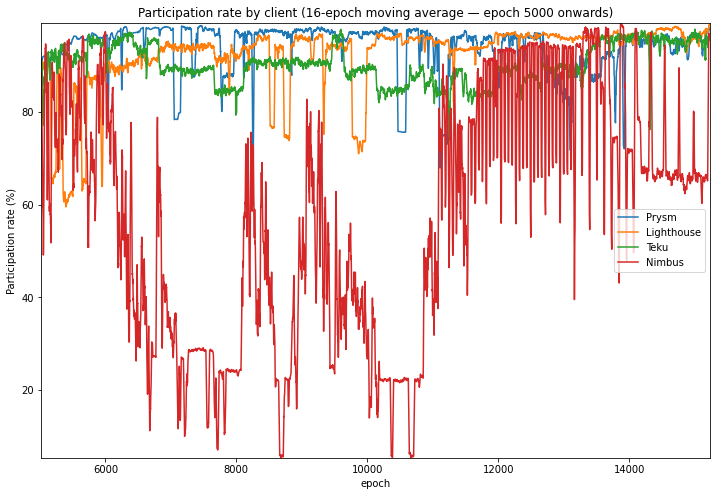

In [6]:
# calculate/describe/plot participation rates by client
participation_rate = {}
for client in clients:
    participation_rate[client] = [100* success_count[client][e] /
                                  (success_count[client][e] + missed_count[client][e]) for e in range(n_epochs)]

participation_rate_df = pd.DataFrame(participation_rate)

print(participation_rate_df.describe())

# plot the participation rate
fig=plt.figure(figsize=(12,8))
plt.plot(participation_rate_df['prysm'].rolling(16).mean(), label='Prysm')
plt.plot(participation_rate_df['lighthouse'].rolling(16).mean(), label='Lighthouse')
plt.plot(participation_rate_df['teku'].rolling(16).mean(), label='Teku')
plt.plot(participation_rate_df['nimbus'].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Participation rate by client (16-epoch moving average)')
plt.xlabel('epoch')
plt.ylabel('Participation rate (%)')
plt.show()

# stats for epoch 5000 onwards
print(participation_rate_df.iloc[5000:].describe())

# plot the participation rate for epoch 5000 onwards
fig=plt.figure(figsize=(12,8))
plt.plot(participation_rate_df['prysm'].iloc[5000:].rolling(16).mean(), label='Prysm')
plt.plot(participation_rate_df['lighthouse'].iloc[5000:].rolling(16).mean(), label='Lighthouse')
plt.plot(participation_rate_df['teku'].iloc[5000:].rolling(16).mean(), label='Teku')
plt.plot(participation_rate_df['nimbus'].iloc[5000:].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Participation rate by client (16-epoch moving average — epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Participation rate (%)')
plt.show()

## Mean inclusion distance
Let's repeat the plot of mean inclusion distance we previously saw for the network as a whole, this time, broken down by client. Again the data is smoothed with a 16-epoch moving average to make it easier to see what's going on.

Mean inclusion distance statistics

              prysm    lighthouse          teku        nimbus
count  15114.000000  15145.000000  14739.000000  14519.000000
mean       1.076769      1.071904      0.869026      0.909243
std        2.797812      2.910695      1.864503      1.406690
min        0.033555      0.011066      0.001393      0.000000
25%        0.315086      0.270033      0.326837      0.376507
50%        0.444371      0.389592      0.505647      0.570352
75%        0.631329      0.578852      0.799285      0.959139
max       29.400000     31.000000     31.000000     31.000000



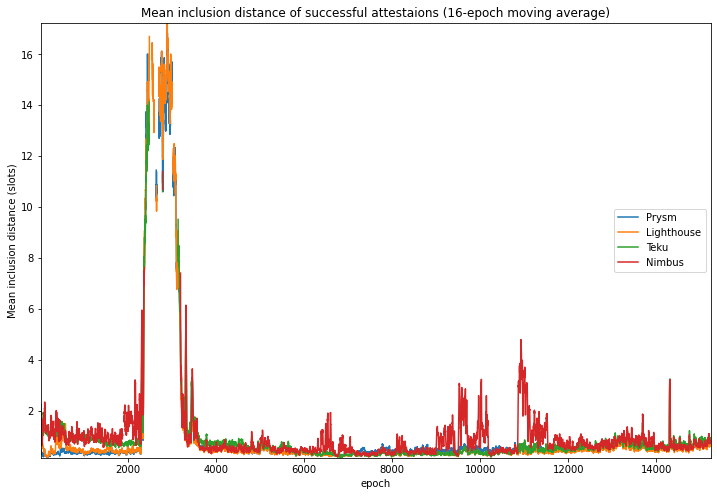

Mean inclusion distance statistics

              prysm    lighthouse          teku        nimbus
count  10238.000000  10238.000000  10238.000000  10238.000000
mean       0.494346      0.413207      0.485343      0.734406
std        0.316168      0.310626      0.367499      0.734332
min        0.035287      0.011066      0.001393      0.034884
25%        0.321582      0.249716      0.274487      0.344783
50%        0.443467      0.354133      0.403502      0.513309
75%        0.600819      0.495992      0.588165      0.813519
max        9.095454      9.010593      8.993289      9.191638



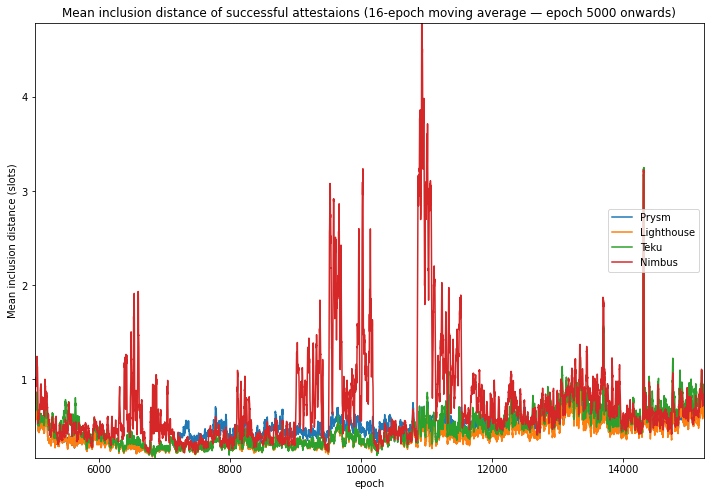

In [7]:
# graphs and stats for mean inclusion distance
mid_df = pd.DataFrame.from_dict(mean_inclusion_distance)

print("Mean inclusion distance statistics\n")
print(mid_df.describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(mid_df['prysm'].rolling(16).mean(), label='Prysm')
plt.plot(mid_df['lighthouse'].rolling(16).mean(), label='Lighthouse')
plt.plot(mid_df['teku'].rolling(16).mean(), label='Teku')
plt.plot(mid_df['nimbus'].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions (16-epoch moving average)')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()

print("Mean inclusion distance statistics\n")
print(mid_df.iloc[5000:].describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(mid_df['prysm'].iloc[5000:].rolling(16).mean(), label='Prysm')
plt.plot(mid_df['lighthouse'].iloc[5000:].rolling(16).mean(), label='Lighthouse')
plt.plot(mid_df['teku'].iloc[5000:].rolling(16).mean(), label='Teku')
plt.plot(mid_df['nimbus'].iloc[5000:].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions (16-epoch moving average — epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()

## Attestation effectiveness

Attestation Effectiveness statistics

              prysm    lighthouse          teku        nimbus
count  15238.000000  15238.000000  15238.000000  15238.000000
mean      84.874990     75.187355     78.999607     45.978212
std       21.813779     25.778578     21.088751     29.421162
min        0.000000      0.000000      0.000000      0.000000
25%       86.609733     61.034018     79.161535     22.455066
50%       91.545155     88.889003     84.889902     45.110669
75%       94.714884     92.898958     89.295413     71.222609
max       98.904054     98.820932     98.750805     97.112029



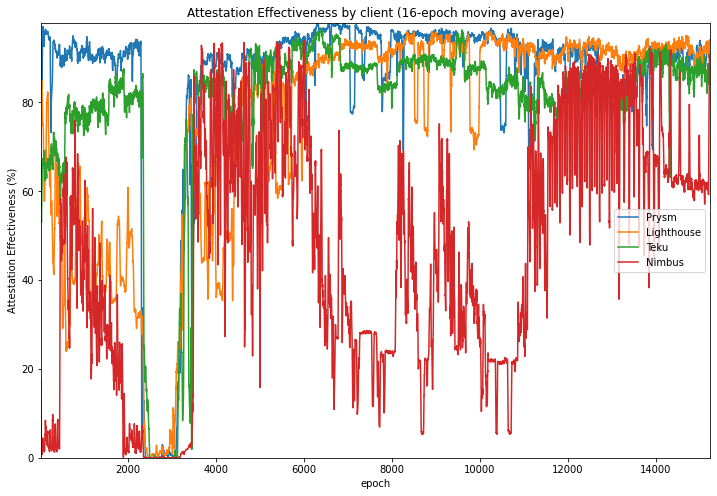

Attestation Effectiveness statistics (epoch 5000 onwards)

              prysm    lighthouse          teku        nimbus
count  10238.000000  10238.000000  10238.000000  10238.000000
mean      90.907902     89.661382     86.539697     52.684304
std        6.497514      7.425171      5.950529     25.886660
min       36.183543     36.895126     15.379269      4.060734
25%       88.392706     88.719859     83.268622     27.335790
50%       93.111943     91.850087     87.224604     56.456293
75%       95.507526     93.955488     90.371962     75.660009
max       98.400035     98.820932     98.750805     97.112029



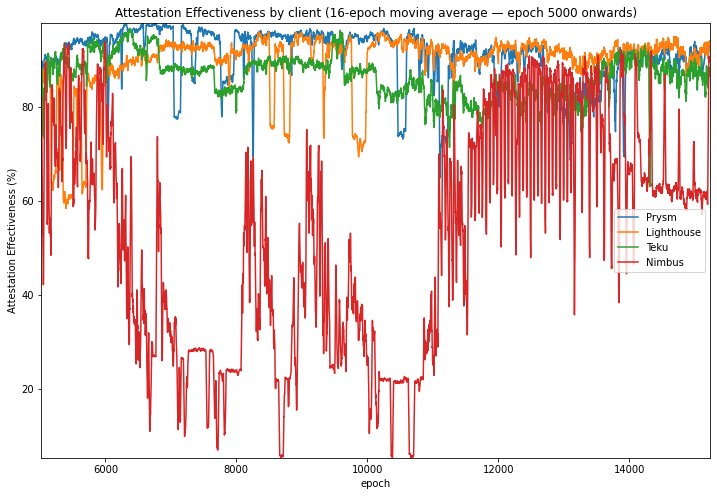

In [8]:
# graphs and stats for attestation effectiveness
ae_df = pd.DataFrame.from_dict(attestation_effectiveness)

print("Attestation Effectiveness statistics\n")
print(ae_df.describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(ae_df['prysm'].rolling(16).mean(), label='Prysm')
plt.plot(ae_df['lighthouse'].rolling(16).mean(), label='Lighthouse')
plt.plot(ae_df['teku'].rolling(16).mean(), label='Teku')
plt.plot(ae_df['nimbus'].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Attestation Effectiveness by client (16-epoch moving average)')
plt.xlabel('epoch')
plt.ylabel('Attestation Effectiveness (%)')
plt.show()

print("Attestation Effectiveness statistics (epoch 5000 onwards)\n")
print(ae_df.iloc[5000:].describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(ae_df['prysm'].iloc[5000:].rolling(16).mean(), label='Prysm')
plt.plot(ae_df['lighthouse'].iloc[5000:].rolling(16).mean(), label='Lighthouse')
plt.plot(ae_df['teku'].iloc[5000:].rolling(16).mean(), label='Teku')
plt.plot(ae_df['nimbus'].iloc[5000:].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Attestation Effectiveness by client (16-epoch moving average — epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Attestation Effectiveness (%)')
plt.show()